In [ ]:
# Before running these commands, create a virtual environment (outside project directory) using python -m venv "dir_name/env_name"
%pip install deepxde
%pip install tensorflow

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
%pip install chart-studio
%pip install nbformat

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import deepxde as dde
import numpy as np

Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.



Instructions for updating:
non-resource variables are not supported in the long term


In [48]:
import tensorflow as tf

geo = dde.geometry.geometry_2d.Rectangle([-1, -1], [1]*2)
points = geo.random_boundary_points(10000)
d = 2
T = 0.005
def dU(x):
    return tf.concat([4.0 * (x[:, 0:1] ** 2 - 1) * x[:, 0:1],
         0.6 * x[:, 1:2]], axis=1)

def committor(x, q):
    dq_list = [dde.gradients.jacobian(q, x, j=i) for i in range(d)]
    grad_q = tf.concat(dq_list, axis=1) 
    dlap_q = sum(dde.gradients.hessian(q, x, i=num, j=num) for num in range(d))
    grad_U = dU(x)
    beta = 1 / T
    dot = tf.reduce_sum(grad_U * grad_q, axis=1, keepdims=True)
    return -1 / beta * dlap_q + dot

bc_a = dde.icbc.DirichletBC(geo, lambda x: 0.0, lambda x, on_boundary: x[0] <= -0.75)
bc_b = dde.icbc.DirichletBC(geo, lambda x: 1.0, lambda x, on_boundary: x[0] >= 0.75)

In [49]:
data = dde.data.pde.PDE(
    geo,
    committor, 
    [bc_a, bc_b], 
    num_domain=2000,
    num_boundary=500,
    num_test=500,
)

In [50]:
net = dde.maps.FNN([2] + [64] * 3 + [1], "tanh", "Glorot normal")
model = dde.Model(data, net)
model.compile("adam", lr=0.001)
losshistory, train_state = model.train(iterations=4000)

Compiling model...
Building feed-forward neural network...
'build' took 0.071785 s

'compile' took 0.835682 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [3.37e-02, 3.54e-02, 7.28e-01]    [3.75e-02, 3.54e-02, 7.28e-01]    []  
1000      [4.55e-04, 1.54e-05, 5.37e-06]    [3.67e-04, 1.54e-05, 5.37e-06]    []  
2000      [2.93e-04, 4.70e-06, 2.81e-06]    [1.95e-04, 4.70e-06, 2.81e-06]    []  
3000      [4.08e-04, 2.12e-04, 2.24e-04]    [3.06e-04, 2.12e-04, 2.24e-04]    []  
4000      [4.51e-05, 5.90e-07, 8.09e-07]    [2.94e-05, 5.90e-07, 8.09e-07]    []  

Best model at step 4000:
  train loss: 4.65e-05
  test loss: 3.08e-05
  test metric: []

'train' took 2179.513102 s



In [51]:
model.compile("L-BFGS-B")
losshistory, train_state=model.train()

Compiling model...
'compile' took 0.719878 s

Training model...

Step      Train loss                        Test loss                         Test metric
4000      [4.51e-05, 5.90e-07, 8.09e-07]    [2.94e-05, 5.90e-07, 8.09e-07]    []  
INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  Objective function value: 0.000047
  Number of iterations: 1
  Number of functions evaluations: 32
4018      [4.51e-05, 5.90e-07, 8.09e-07]    [2.94e-05, 5.90e-07, 8.09e-07]    []  

Best model at step 4000:
  train loss: 4.65e-05
  test loss: 3.08e-05
  test metric: []

'train' took 3.410343 s



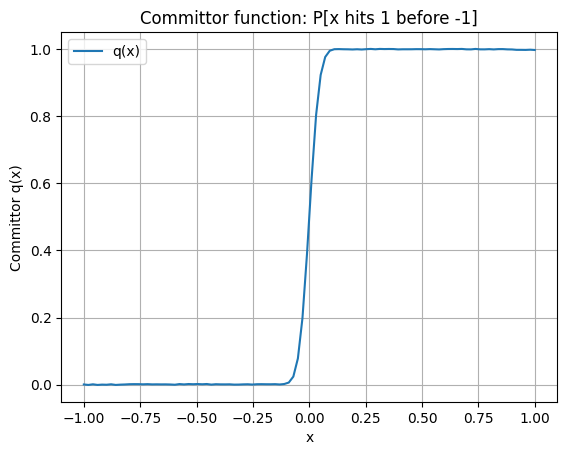

In [53]:
import matplotlib.pyplot as plt

sample = np.linspace(-1, 1, 100).reshape(-1, 1)
sample = np.concat([sample, np.random.uniform(-1, 1, 100).reshape(-1, 1)], axis=1)

u_pred = model.predict(sample)

plt.plot(sample[:, 0], u_pred, label="q(x)")
plt.xlabel("x")
plt.ylabel("Committor q(x)")
plt.title("Committor function: P[x hits 1 before -1]")
plt.grid(True)
plt.legend()
plt.show()
